In [1]:
from langchain.globals import set_debug,set_verbose
# set_debug(True)
# set_verbose(True)

In [2]:
import os
os.environ['TAVILY_API_KEY'] = '<your api key>'
model_id = 'anthropic.claude-3-haiku-20240307-v1:0'

In [3]:
from langchain_aws import ChatBedrockConverse, ChatBedrock
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage,BaseMessage,ToolMessage

In [4]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_research_agent(llm, tools, system_message):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful research assistant, collaborating with a visualizer."
                " Use the provided tools to progress towards answering the question."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

def create_chart_generator_agent(llm, tools, system_message):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful visualizer."
                " Use the provided tools to progress towards answering the question."
                " Prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=3)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [6]:
import operator
from typing import Annotated, Sequence, TypedDict

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [7]:
import functools

from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    messages = state['messages']
    if isinstance(messages[-1],AIMessage):
        messages = messages[:-1]
    result = agent.invoke(messages)
    
    # result always returns AIMessage
    # we assume here that only messages containing tool calls or the final answer ('FINAL ANSWER') are useful
    # results with tool_calls will be passed on to the ToolNode to be executed
    
    # We convert the agent output into a format that is suitable to append to the global state
    if result.tool_calls or 'FINAL ANSWER' in result.content:
        return {
            "messages": [result],
            # Since we have a strict workflow, we can
            # track the sender so we know who to pass to next.
            "sender": name,
        }
    else:
        return {
            "messages": [],
            # Since we have a strict workflow, we can
            # track the sender so we know who to pass to next.
            "sender": name,
        }

llm = ChatBedrockConverse(model=model_id,temperature=0)

# Research agent and node
research_agent = create_research_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the Visualizer to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Visualizer
chart_agent = create_chart_generator_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Visualizer")

In [8]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [9]:
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    # last_message can be a ToolMessage if the result from the agent node is an AIMessage without any tool calls - i.e. the result is not added to the state
    # this will mean that the agent has made a redundant step and the next step should be executed by other agents
    if isinstance(last_message,ToolMessage):
        return 'continue'
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [10]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Visualizer", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Visualizer", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "Visualizer",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Visualizer": "Visualizer",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

{'Researcher': {'messages': [AIMessage(content=[{'type': 'text', 'text': "Okay, let's fetch the data on Singapore's GDP over the past 5 years and then visualize it."}, {'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'Singapore GDP past 5 years'}, 'id': 'tooluse_0cuF_kgQSxGPLWDFQCXAzA'}], response_metadata={'ResponseMetadata': {'RequestId': '79beab93-5842-4b63-adc5-2e2b37f495dd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 16 Aug 2024 05:50:52 GMT', 'content-type': 'application/json', 'content-length': '415', 'connection': 'keep-alive', 'x-amzn-requestid': '79beab93-5842-4b63-adc5-2e2b37f495dd'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 830}}, id='run-0a918bd5-ba99-4300-9901-1f8153dab958-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Singapore GDP past 5 years'}, 'id': 'tooluse_0cuF_kgQSxGPLWDFQCXAzA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 449, 'output_tokens': 90, 'total_to

Python REPL can execute arbitrary code. Use with caution.


{'Visualizer': {'messages': [AIMessage(content=[{'type': 'tool_use', 'name': 'python_repl', 'input': {'code': "import matplotlib.pyplot as plt\nimport numpy as np\n\n# Fetch the GDP growth data for the past 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_growth_rates = [3.1, -5.4, 7.6, 3.6, 2.2]\n\n# Create the line chart\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_growth_rates)\nplt.xlabel('Year')\nplt.ylabel('GDP Growth Rate (%)')\nplt.title('Singapore GDP Growth Rate (Past 5 Years)')\nplt.grid(True)\nplt.show()"}, 'id': 'tooluse_FXBg6dOKTI2xIbOltUrwtg'}], response_metadata={'ResponseMetadata': {'RequestId': 'a2ea5587-50ad-4e9e-96e6-96e95820486c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 16 Aug 2024 05:51:09 GMT', 'content-type': 'application/json', 'content-length': '694', 'connection': 'keep-alive', 'x-amzn-requestid': 'a2ea5587-50ad-4e9e-96e6-96e95820486c'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 2139}}, id='run-17b8730d-a76e

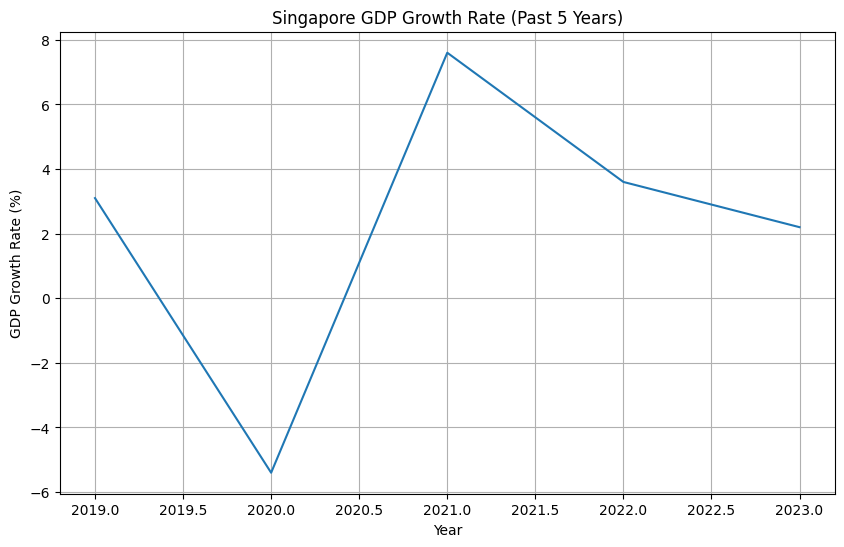

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Fetch the GDP growth data for the past 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_growth_rates = [3.1, -5.4, 7.6, 3.6, 2.2]\n\n# Create the line chart\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_growth_rates)\nplt.xlabel('Year')\nplt.ylabel('GDP Growth Rate (%)')\nplt.title('Singapore GDP Growth Rate (Past 5 Years)')\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='tooluse_FXBg6dOKTI2xIbOltUrwtg')]}}
----
{'Visualizer': {'messages': [AIMessage(content="FINAL ANSWER\n\nThe visualization shows Singapore's GDP growth rate over the past 5 years. The key insights are:\n\n- Singapore's GDP growth rate has fluctuated significantly, ranging from a high of 7.6% in 2021 to a low of -5.4% in 2020 during the COVID-19 pandemic.\n- The growth rate has be

In [11]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch Singapore's GDP over the past 5 years. The final output should contain a visualization rendered with code."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 50},
)
for s in events:
    print(s)
    print("----")